In [ ]:
## https://medium.com/analytics-vidhya/facial-emotion-recognition-using-convolutional-bidirectional-lstm-49d4199024f
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install scikit-plot
import os
import cv2
import numpy as np
from collections import defaultdict
import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
#------------------------------------------------------------------------------
# Data overview
#------------------------------------------------------------------------------

In [ ]:
INPUT_PATH = '/content/drive/Shareddrives/cis600/600Paper/DataSet/CK+48/'

In [ ]:
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        if f == 'Untitled':
          continue
        count += 1
    print(f"{dir_} has {count} number of images")

disgust has 177 number of images
contempt has 54 number of images
fear has 75 number of images
sadness has 84 number of images
happy has 207 number of images
surprise has 249 number of images
anger has 135 number of images


In [ ]:
TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

In [ ]:
INPUT_PATH = '/content/drive/Shareddrives/cis600/600Paper/DataSet/CK+48/'
data = defaultdict(str)
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        data[dir_] = defaultdict(list)
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            sub = f.split("_")[0]
            data[dir_][sub].append(f)

In [ ]:
def preprocess_list(x):
    return int((x.split("_")[2]).split(".")[0])

def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]

def img2array(x,path):
    arr = np.empty(shape=(3,48,48))
    for i,f in enumerate(x):
        img = cv2.imread(path+f, 0)
        arr[i] = img
    return arr

In [ ]:
for emotion in data:
    data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
    data[emotion] = dict((k, img2array(v, path=INPUT_PATH + emotion + "/")) for k, v in data[emotion].items())
    
for k,v in data.items():
    print(f"{k} has {len(v)} samples")

fear has 25 samples
sadness has 28 samples
happy has 69 samples
surprise has 83 samples
anger has 45 samples


In [ ]:
surprise = np.stack(data["surprise"].values(), axis=0)
surprise = surprise.reshape(*surprise.shape,1)

happy = np.stack(data["happy"].values(), axis=0)
happy = happy.reshape(*happy.shape,1)

anger = np.stack(data["anger"].values(), axis=0)
anger = anger.reshape(*anger.shape,1)

sadness = np.stack(data["sadness"].values(), axis=0)
sadness = sadness.reshape(*sadness.shape,1)

fear = np.stack(data["fear"].values(), axis=0)
fear = fear.reshape(*fear.shape,1)

X = np.concatenate((surprise, happy, anger, sadness, fear))
y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))
y = np_utils.to_categorical(y)

print(X.shape, y.shape) # (250, 3, 48, 48, 1), (250, 5)

(250, 3, 48, 48, 1) (250, 5)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
label_emotion_mapper = {0:"surprise", 1:"happy", 2:"anger", 3:"sadness", 4:"fear"}

X_train, X_valid, y_train, y_valid = train_test_split(
  X,
  y,
  train_size=0.7,
  stratify=y,
  shuffle=True,
  random_state=42
)

print(X_train.shape, X_valid.shape)

(175, 3, 48, 48, 1) (75, 3, 48, 48, 1)


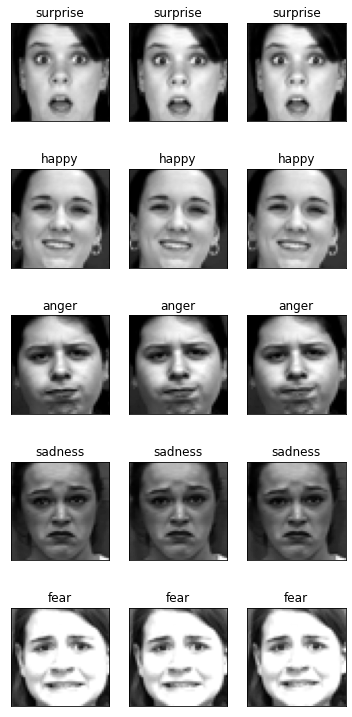

In [ ]:
np.random.seed(42)
surprise_idx = np.random.choice(np.where(y_train[:, 0]==1)[0], size=1)
happy_idx = np.random.choice(np.where(y_train[:, 1]==1)[0], size=1)
anger_idx = np.random.choice(np.where(y_train[:, 2]==1)[0], size=1)
sad_idx = np.random.choice(np.where(y_train[:, 3]==1)[0], size=1)
fear_idx = np.random.choice(np.where(y_train[:, 4]==1)[0], size=1)

fig = pyplot.figure(1, (6,13))

i = 0
for name, idx in zip(label_emotion_mapper.values(), [surprise_idx, happy_idx, anger_idx, sad_idx, fear_idx]):
    for j in range(3):
        i += 1
        ax = pyplot.subplot(5,3,i)
        sample_img = X_train[idx][0,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)

In [ ]:
# data normalization
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
def build_dcnn(input_shape, show_arch=True):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.45, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.45, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.4, name='dropout_3'))

    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_7'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_8'
        )
    )
    net.add(BatchNormalization(name='batchnorm_8'))
    
    net.add(Dropout(0.4, name='dropout_4'))
    
    net.add(GlobalMaxPool2D(name="globalmax2d"))
    
    if show_arch:
        net.summary()
    
    return net

In [ ]:
def memory_model(input_shape, num_class, show_arch=True):
    dcnn = build_dcnn(input_shape[1:], show_arch=False)
    
    model = Sequential(name="convolutional_Bidrectional_LSTM")

    model.add(
        TimeDistributed(
            dcnn,
            input_shape=input_shape,
            name="time_distributed",
        )
    )
    
    model.add(LSTM(128, return_sequences=True, name="lstm_1"))
    model.add(Dropout(.35, name="dropout_1"))
    model.add(LSTM(64, return_sequences=False, name="lstm_2"))
    model.add(Dropout(.45, name="dropout_2"))

    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Dropout(.7, name="dropout_3"))

    model.add(
        Dense(
            num_class,
            activation='softmax',
            name='out_layer'
        )
    )
    
    if show_arch:
        model.summary()
    
    return model

In [ ]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    lr_scheduler,
]

batch_size = 32
epochs = 100

In [ ]:
INPUT_SHAPE = (3, 48, 48, 1)
optim = optimizers.Nadam(0.001)

model = memory_model(INPUT_SHAPE, num_class=5)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

Model: "convolutional_Bidrectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 3, 512)           4691904   
 ibuted)                                                         
                                                                 
 lstm_1 (LSTM)               (None, 3, 128)            328192    
                                                                 
 dropout_1 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                   

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)


Epoch 1/100
6/6 [==============================] - 24s 925ms/step - loss: 2.8122 - accuracy: 0.2343 - val_loss: 1.5660 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 2s 310ms/step - loss: 3.3077 - accuracy: 0.1943 - val_loss: 1.5503 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 2s 283ms/step - loss: 2.9441 - accuracy: 0.2229 - val_loss: 1.5044 - val_accuracy: 0.3600 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 2s 280ms/step - loss: 3.1524 - accuracy: 0.2057 - val_loss: 1.5173 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 2s 276ms/step - loss: 3.0640 - accuracy: 0.1943 - val_loss: 1.5269 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 2s 279ms/step - loss: 3.0873 - accuracy: 0.1943 - val_loss: 1.5096 - val_accuracy: 0.3200 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 2s 279ms/step - loss: 2.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

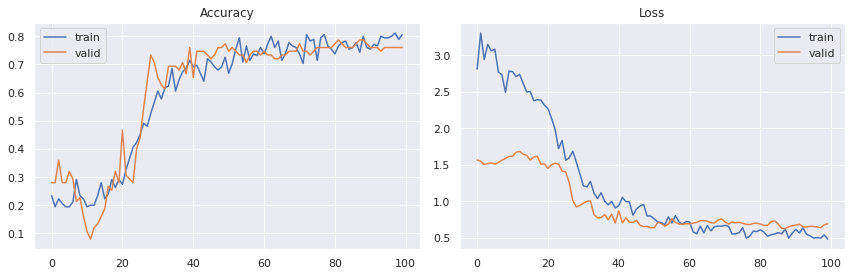

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

total wrong validation predictions: 18


              precision    recall  f1-score   support

           0       1.00      0.84      0.91        25
           1       0.91      1.00      0.95        21
           2       0.48      1.00      0.65        13
           3       0.00      0.00      0.00         8
           4       1.00      0.25      0.40         8

    accuracy                           0.76        75
   macro avg       0.68      0.62      0.58        75
weighted avg       0.78      0.76      0.73        75



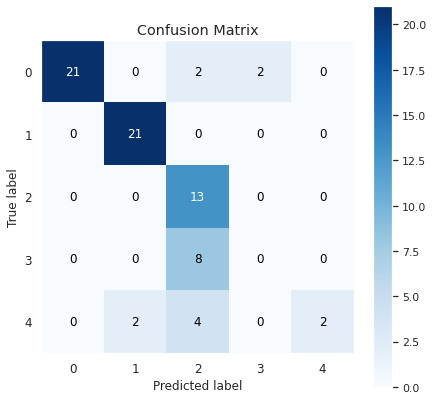

In [ ]:
#yhat_valid = model.predict_classes(X_valid)

predict_x=model.predict(X_valid) 
yhat_valid=np.argmax(predict_x,axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))


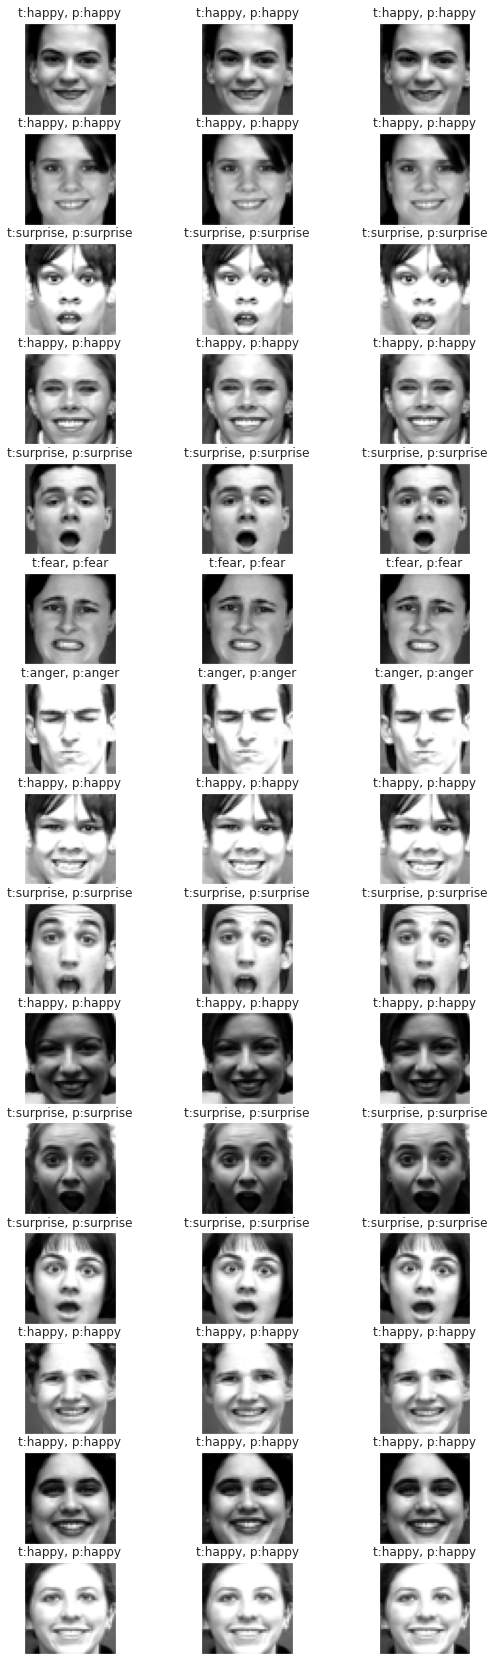

In [ ]:
np.random.seed(0)
indices = np.random.choice(range(X_valid.shape[0]), size=15, replace=False)

fig = pyplot.figure(1, (9,30))

i = 0
for idx in indices:
    true_emotion = label_emotion_mapper[np.argmax(y_valid[idx])]
    predict_x=model.predict(np.expand_dims(X_valid[idx], axis=0))
    pred_emotion = label_emotion_mapper[np.argmax(predict_x,axis=1)[0]]
    
    #
    #yhat_valid=np.argmax(predict_x,axis=1)

    for j in range(3):
        i += 1
        ax = pyplot.subplot(15,3,i)
        sample_img = X_valid[idx,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:{true_emotion}, p:{pred_emotion}")